<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/Exploration_quest/exploration_2/xp2_amazon_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploration 2. Natural Language Process

**Goal**

* `Extractive/Abstractive summarization` 이해할 수 있습니다.
* 단어장 크기를 줄이는 다양한 text normalization 적용할 수 있습니다.
* `seq2seq`의 성능을 Up시키는 `Attention Mechanism` 적용할 수 있습니다.

**Index**

    1. Introduction
    2. Text Summarization
    3. Training text summarization
    4. Prep Data
    5. Data Preprocessing (1) Organizing data
    6. Data Preprocessing (2) Divide training data and test data
    7. Data Preprocessing (3) Integer encoding
    8. Design Model
    9. Training
    10. Implementing the inference model
    11. Test
    12. Extractive Summarization

### 2. Text Summarization

**Q. RNN은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 문제가 있습니다. 이 문제를 해결하기 위해 LSTM과 GRU가 등장했고, 나아가 Attention 메커니즘이 등장했지요. 이 문제의 이름은 무엇인가요?**
```
Long-Term Dependency 문제로 알려져 있습니다. RNN은 시퀀스 데이터를 처리하는 데 강력하지만, 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 기억하고 전달하기 어려워지는 경향이 있습니다. 이로 인해 모델이 장기 의존성을 적절하게 학습하지 못하고 성능이 제한됩니다.
```

**Q. 텍스트마이닝 분야의 IDF 같은 지표를 활용해 문서 내 중요한 부분을 추출하고 그것을 요약문에 담는 방식을 썼을 때의 문제점은 무엇인가요?**
```
텍스트 요약에서 역문서빈도(IDF)나 다른 중요성 지표를 사용하는 방식은 일반적으로 중요한 단어나 구를 추출하여 요약문을 생성하는 데 활용됩니다. 그러나 이러한 방식에는 문맥의 부재 / 일관성 부족 / 의미의 손실 / 문서의 다양성 무시와 같은 문제점이 있을 수 있습니다.
```

**Q. 구글은 짧은 문장. 요약문을 생성하는 모델을 딥러닝을 통해 end-to-end으로 설계했어요. 구글 메일서비스의 Smart Reply 기능과 비슷한 딥러닝 기법으로 인코더와 디코더의 구조로 구성된 이 아키텍처의 이름은 무엇인가요?**
```
구글이 짧은 문장 요약 및 자동 회신 Smart Reply 과 관련하여 사용한 딥 러닝 아키텍처는 Seq2Seq, Sequence-to-Sequence 입니다. Seq2Seq는 주로 기계 번역에서 시작되었으며, 인코더 Encoder와 디코더 Decoder로 구성된 구조를 가지고 있습니다. Seq2Seq 아키텍처는 입력과 출력 시퀀스의 길이가 다를 수 있으며, 특히 가변 길이 시퀀스에 적합합니다. 이러한 구조는 자연어 처리 및 기타 시퀀스 변환 작업에서 널리 사용되고 있습니다. Smart Reply와 같은 응용 프로그램에서는 짧은 문장에 대한 요약이나 자동 회신을 생성하는 데 활용될 수 있습니다.
```

### 3. Training text summarization

**Q. SOS 토큰과 EOS 토큰을 사용하는 이유가 무엇인가요?**
```
SOS 토큰은 디코더에 입력되는 첫 번째 토큰으로 사용되며, 디코더가 문장 생성을 시작하도록 합니다. EOS 토큰은 디코더가 문장 생성을 끝내야 할 때 사용되며, 디코더가 문장 생성을 멈추게 합니다. 즉, SOS 토큰과 EOS 토큰은 seq2seq 모델이 문장 생성을 시작하고 끝내는 시점을 알려주는 역할을 합니다.
```

**Q. Attention 모델과 seq2seq 모델의 차이점이 무엇인가요?**
```
Attention 모델에서는 모든 스텝의 hidden state 정보가 컨텍스트 벡터에 반영됩니다. 그리고 디코더가 출력을 생성할 때, 컨텍스트 벡터에 반영된 각각의 hidden state에 대한 가중치 값은 디코더의 현재 스텝이 어딘지에 따라 다르게 반영됩니다.
```

### 4. Prep Data

텍스트 요약 모델 학습에 사용할 데이터셋은 Kaggle에서 제공된 [Amazon Product Reviews Dataset](https://www.kaggle.com/datasets/yasserh/amazon-product-reviews-dataset) 입니다. 이번 실습에서는 `NLTK`의 불용어 `stopwords` 를 사용할 거에요. NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리 입니다. 자 그럼, NLTK 패키지에서 불용어 사전을 다운로드 하고, 데이터 전처리를 위한 나머지 패키지도 함께 설치할까요?

In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print("Heya")

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Heya


다운로드 받은 데이터 `Reviews.csv` 는 총 `568,454` 개의 샘플을 가지고 있습니다. 간단히 `10만 개`의 샘플만 사용해 볼게요.

In [ ]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


출력된 샘플 수를 보면 총 10만 개의 샘플이 잘 불러와진 것을 확인할 수 있습니다. 이 중에 5개만 출력해 볼까요?

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


열이 너무 많아서 보기에 조금 까다롭죠? 사실 전체 데이터 중 `Summary` 열과 `Text` 열만 훈련에 사용할 거에요. 다시 출력해 볼게요.

**Q. 데이터프레임 data의 Text와 Summary 컬럼의 데이터만 남기는 코드를 작성하세요.**

In [ ]:
data = data[['Text', 'Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
87792,Stash Chamomile Herbal Tea is tea bags with dr...,"A ginormous box of 1,000 tea bags"
48798,Love this freezer tray. I set it on the count...,Perfect freezer tray
51338,Stevia is kind of funny. Brands and batches va...,Bad batch of Stevia
38762,"Product, was a great Christmas gift, and well ...",popcorn 3 pack
1173,Well one of my friends asked for a really big ...,Gummy Bears
13633,Tastes like pine needles!!! I've had other ear...,YUCK!!! Buy another variety!!!
36593,I have used the noodle in several recipes and ...,Miracle Noodle=WOW
3147,My family and I all agree that Hodgson Mill Po...,Potato Bread Winner
31524,"Like many others, I've been so addicted to Dun...",Very delicious!!
30418,I was so excited to order and receive this cof...,No pumpkin flavor


Text 열의 내용을 요약한 것이 Summary 열이에요.  
여기서는 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 거예요.  

### 5. Data Preprocessing (1) Organizing data

**중복 샘플과 NULL 값이 존재하는 샘플 제거**

우선 데이터의 중복 샘플 유무를 확인해 볼게요.

In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


중복을 제외하면 `Text에는 88,426개`, `Summary에는 72,348개` 의 유니크한 데이터가 존재해요. 사실 이 데이터의 Summary는 'Smelly'나 'Good Product'와 같이 아주 간단한 요약들도 많아서 Text가 달라도 Summary는 동일할 수 있어요. 하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야겠죠? 데이터 프레임의 `drop_duplicates()`를 사용하면, 손쉽게 중복 샘플을 제거할 수 있습니다.

In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다.

data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


중복이 제거되어 샘플 수가 `88,426`개가 되었어요. 그런데 만약 데이터 Null 값을 가지는 샘플이 있었다면? `drop_duplicates()`이 중복된 Null들을 지우겠지만 여전히 어딘가에 Null 값이 남아 있을 수 있어요. 데이터에 Null 값이 남아 있는지 `.isnull().sum()` 을 사용하여 확인해 볼게요.

In [ ]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


Summary에 1개의 Null 값이 있네요? 데이터 프레임에서 Null을 제거하기 위해 `dropna()` 함수를 사용하겠습니다.

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


이제 전체 샘플 수는 `88,425개`입니다. 중복 샘플과 Null 값이 있는 샘플들을 제거하니 10만 개의 샘플 중 1만 개 이상의 샘플이 제거되었어요.

**텍스트 정규화와 불용어 제거**

같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우는 어떻게 처리할까요? 예를 들어서 `it'll` 은 `it will` 과 같고, `mustn't` 과 `must not` 은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 정리하는 것이 기계의 연산량을 줄일 수 있답니다. 이러한 방법론을 텍스트 정규화 `text normalization` 라고 합니다.

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재합니다. 이를 불용어 `stopwords` 라고 해요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요. NLTK에서 제공하는 불용어 리스트를 참조해 샘플에서 불용어를 제거할 거예요.

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 `179개` 라는 것을 알 수 있습니다. 이를 사용하여 불용어를 제거하겠습니다. 이 작업 외에도 모든 영어 문자는 `소문자`로 만들고, 섞여 있는 `html 태그를 제거`하고, 정규 표현식을 통해 각종 `특수문자를 제거`해서 필요한 내용만 학습할 수 있도록 처리하겠습니다. NLTK를 이용해 불용어를 제거하는 파트가 있는데 이는 Text 전처리 시에서만 호출하고, 이미 상대적으로 문장 길이가 짧은 Summary를 전처리 할 때는 호출하지 않을 거에요. 추상적인 문장 요약의 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋습니다. 이를 위해서  `remove_stopwords`와 `if` 문을 추가했어요.

In [ ]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print("Gotcha")

Gotcha


전처리 전후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해 볼까요?

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 진행하겠습니다. 이 때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행하니다. 먼저 Text를 전처리하고, 결과를 확인하기 위해 상위 5개의 줄을 출력해볼게요.

**Q. 훈련 데이터 전체의 Text 컬럼 데이터를 전처리하는 코드를 작성하세요. (반복문 사용)**

In [ ]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.

clean_text = []

for text in data['Text']:
    clean_text.append(preprocess_sentence(text))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


이제 Summary에 대해서 전처리를 진행하겠습니다. 함수를 호출해 줄 때는 불용어 제거를 수행하지 않으므로 두 번째 인자로 `False`를 적용합니다.

**Q. 훈련 데이터 전체의 Summary 컬럼 데이터를 전처리하는 코드를 작성하세요. (반복문 사용)**

In [ ]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_summary = []

for summary in data['Summary']:
    clean_summary.append(preprocess_sentence(summary, False))

# 전처리 후 출력
print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈 샘플이 생겼는지 확인하는 것이 좋아요. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈값을 가지게 되겠죠? 보다 쉽게 확인하기 위해 데이터들을 데이터 프레임에 다시 저장할게요. 빈값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체하겠습니다.

In [ ]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print("Yar")

Yar


`.isnull().sum()` 을 사용해서 Null 값이 생겼는지 확인해 볼게요.

In [ ]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

Summary 열에서 70개의 Null 값이 생겼네요? 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼어요. 이 샘플들은 모두 제거할게요.

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


### 6. Data Preprocessing (2) Divide training data and test data

**샘플의 최대 길이 정하기**

원본 데이터에서 필요 없는 단어를 모두 정리했어요. 이제 훈련에 사용할 샘플의 최대 길이를 정할게요.  
Text와 Summary의 최소 / 최대 / 평균의 길이를 구하고, 또한 길이 분포를 시각화해서 확인하겠습니다.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


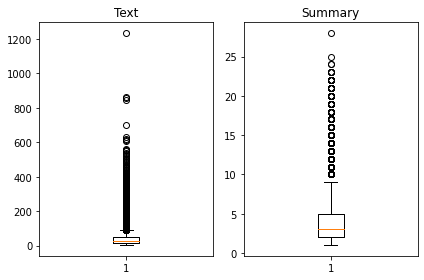

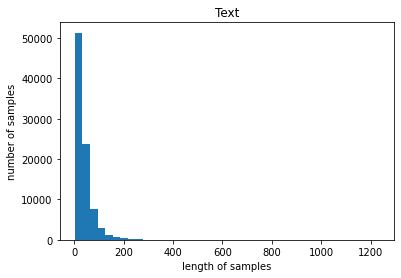

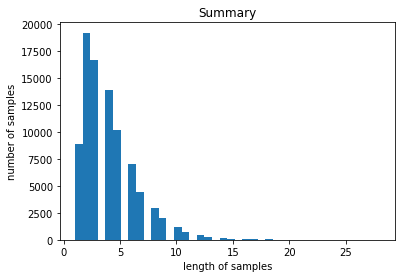

In [ ]:
# 길이 분포 출력

import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서부터 차례대로 그래프는 각각 `실제 텍스트와 요약의 길이 분포`, `실제 텍스트 샘플 길이 별 개수`, `요약본 샘플 길이 별 개수`를 나타내고 있어요.

Text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 크죠? 하지만 평균 길이는 38로 시각화 된 그래프로 봤을 때 대체적으로는 100 내외의 길이를 가집니다. Summary의 경우, 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10 이하의 길이를 가지고 있습니다. 위의 결과를 토대로 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정합니다.

In [ ]:
text_max_len = 50
summary_max_len = 8

print("Yar")

Yar


각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하면 객관적으로 길이를 결정하는 데 도움이 될 거예요.  
훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해 봅시다.

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

print("Yar")

Yar


이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇 %의 샘플까지 포함하는지 볼 수 있겠죠?

In [ ]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.
우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

**Q. Text와 Summary를 담고 있는 데이터 프레임을 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외하는 코드를 작성하세요. (apply 함수와 lamda식 사용)**

In [ ]:
text_max_len = 50
summary_max_len = 8

data = data[data.apply(lambda x: len(x['Text'].split()) <= text_max_len and len(x['Summary'].split()) <= summary_max_len, axis=1)]

print('전체 샘플수 (최대 길이 이하):', len(data))

전체 샘플수 (최대 길이 이하): 65818


**시작 토큰과 종료 토큰 추가하기**

`seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요`. 이번 실습에서는 시작 토큰은 `sostoken`, 종료 토큰은 `eostoken` 이라 임의로 명명하고 앞뒤로 추가하겠습니다. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target` 이라고 정하겠습니다. 두 개의 문장 모두 Summary 열로부터 만들 거예요.

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가

data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


앞뒤로 토큰이 추가되었습니다. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [ ]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

이제 훈련 데이터와 테스트 데이터를 분리하겠습니다. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어 봅시다.

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[46167 41298 37751 ... 19482 55667 58116]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의하면 잘 섞인 샘플이 되겠죠?

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 섞인 데이터를 `8:2의 비율`로 훈련 데이터와 테스트 데이터로 분리하겠습니다. 전체 데이터의 크기에서 0.2를 곱하여 테스트 데이터의 크기를 정의하겠습니다.

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분하겠습니다.

In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


훈련 데이터와 테스트 데이터가 각각 `52,655개`와 `13,163개`로 잘 분리된 것을 확인했습니다.

### 7. Data Preprocessing (3) Integer encoding

**Vocabulary 만들기 및 정수 인코딩**

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 변환해야 합니다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합 `Vocabulary`을 만든다 라고 표현합니다. 훈련 데이터에 대해서 단어 집합을 만들어 보겠습니다. 우선, 원문에 해당되는 `encoder_input_train`에 대해 단어 집합을 만들겠습니다. Keras의 `Tokenizer()`를 사용하면 입력된 훈련 데이터로부터 단어 집합을 만들 수 있습니다.

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

print("Gotcha")

Gotcha


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장되어 있습니다. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아닙니다. 빈도수가 낮은 단어들은 훈련 데이터에서 제외할 거에요. 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해 보겠습니다. `src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어 있는데, 이를 통해서 통계적인 정보를 얻을 수 있습니다.

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31957
등장 빈도가 6번 이하인 희귀 단어의 수: 23700
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8257
단어 집합에서 희귀 단어의 비율: 74.1621553963138
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3874079615702644


`encoder_input_train`에는 `3만여 개`의 단어가 있네요. 그 아래의 통계 정보들을 해석해 볼까요?

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39% 입니다. 그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 제외하고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한하겠습니다. `토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있습니다.`

In [ ]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print("Gotcha")

Gotcha


`texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행합니다.  
현재 단어 집합의 크기를 8,000으로 제한했으니, 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.  

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[244, 16, 376, 72, 1026, 1453, 57, 27, 601, 721, 3259, 1753], [35, 52, 355, 889, 162, 11, 1229, 829, 91, 562, 66, 7, 93, 1200, 385], [168, 5095, 5, 374, 352, 1827, 9, 2764, 1561, 1561, 712, 22, 5, 768, 138, 1084, 15, 165, 83, 296, 7159, 239, 5, 57, 15, 99, 58, 57, 855, 2658, 814]]


이제 더 이상 텍스트 데이터가 아닌 정수로 나타나고 있어요. Summary 데이터에 대해서도 동일한 작업을 수행하겠습니다. 케라스의 토크나이저를 사용하여 `decoder_input_train`을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해 봅시다.

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print("Gotcha")

Gotcha


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 `tar_tokenizer.word_index`에 저장되어 있어요. `tar_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어 있는데, 이를 통해서 통계적인 정보를 얻어서 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인하겠습니다.

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10527
등장 빈도가 5번 이하인 희귀 단어의 수: 8148
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2379
단어 집합에서 희귀 단어의 비율: 77.4009689370191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.919577887367659


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있습니다. 하지만 실제 훈련 데이터에서 등장 빈도로 차지하는 비중은 5.87% 밖에 되지 않아요. 앞서 진행했던 작업과 동일하게 이 단어들은 모두 제거하겠습니다. 어림잡아 2,000을 단어 집합의 크기로 제한해 봅시다.

In [ ]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1], [1, 29, 18, 77, 6, 1212, 22, 490], [1, 27, 1826, 7, 1827, 1363], [1, 465, 23, 498, 22, 30], [1, 946, 14]]
target
decoder  [[2], [29, 18, 77, 6, 1212, 22, 490, 2], [27, 1826, 7, 1827, 1363, 2], [465, 23, 498, 22, 30, 2], [946, 14, 2]]


정수 인코딩 작업이 끝났습니다. 현재 `decoder_input_train`과 `decoder_target_train`에는 더 이상 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 `패딩`으로 넘어가기 전에 한 가지 점검해야 할 것이 있습니다. 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문 Text의 경우에는 문제되지 않지만 애초에 평균 길이가 4 정도 였던 Summary의 경우 이 현상이 굉장히 두드러졌을 가능성이 높겠죠?  

요약문에서 길이가 0이 된 샘플들의 인덱스를 받겠습니다. 여기서 주의할 점은 요약문인 `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 `길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요`. 길이가 0이 된 `decoder_input`에는 `sostoken`, `decoder_target`에는 `eostoken`만 남아 있을 테니까요. 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 라는 변수에 저장하겠습니다. 이 샘플들은 모두 삭제할 거예요.

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1273
삭제할 테스트 데이터의 개수 : 344
훈련 데이터의 개수 : 51382
훈련 레이블의 개수 : 51382
테스트 데이터의 개수 : 12819
테스트 레이블의 개수 : 12819


훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인할 수 있습니다.

**패딩하기**

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬로 처리하기 위해 같은 길이로 맞춰주는 패딩 작업이 필요합니다. 앞서 정해두었던 최대 길이로 패딩을 진행하겠습니다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰 봅시다.

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

print("Are you ready?")

Are you ready?


이제 학습에 필요한 데이터 전처리가 모두 끝났어요.

### 8. Design Model

이제 모델을 설계하겠습니다. 우선 함수형 API를 이용해서 인코더를 설계하겠습니다.

**Q.인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성하세요.**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1, initial_state=[state_h1, state_c1])

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2, initial_state=[state_h2, state_c2])

`임베딩 벡터의 차원은 128`로 정의하고, `hidden state의 크기를 256`으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지 정하는 파라미터입니다. 이 파라미터는 LSTM 용량의 크기나, LSTM 에서의 뉴런 개수라고 이해하면 되겠습니다. 다른 신경망과 마찬가지로 무조건 용량을 많이 늘린다고 성능이 반드시 올라가는 것은 아닙니다. 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있습니다. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내야겠죠?

LSTM은 dropout 뿐 아니라 `recurrent dropout`을 사용할 수 있어요. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합을 해결해주는 방법입니다. 반면 recurrent dropout은 dropout을 레이어가 아닌 time step 마다 적용하는 방식이에요. 즉, time step의 입력을 랜덤으로 생략하는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있습니다. 참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜹니다.

```
WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
```

`recurrent dropout`을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸립니다. recurrent dropout에 대한 자세한 내용은 [Recurrent Dropout without Memory Loss](https://arxiv.org/pdf/1603.05118v2.pdf) 논문을 참고하세요. 이제 디코더를 설계해 봅시다.

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하니다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 합니다. 디코더의 출력층을 설계해 봅시다.

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

`디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수 많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 합니다.` 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용합니다. 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 `seq2seq` 모델입니다. 그런데 디코더의 출력층 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있습니다. 바로 `어텐션 메커니즘`.

**어텐션 메커니즘**

어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 의미입니다. 어텐션 함수를 설계하는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 봅시다. 참고로 여기서 사용하는 어텐션 함수는 `Bahdanau 스타일의 어텐션`입니다. 이 어텐션에 대한 자세한 설명은 [텐서플로우 홈페이지](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention)를 참고하세요. 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동합니다.

### 9. Training

앞서 설계한 모델로 훈련을 진행해 봅시다.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 123s 438ms/step - loss: 2.7018 - val_loss: 2.4327
Epoch 2/50
201/201 [==============================] - 87s 434ms/step - loss: 2.3761 - val_loss: 2.3263
Epoch 3/50
201/201 [==============================] - 88s 437ms/step - loss: 2.2510 - val_loss: 2.1842
Epoch 4/50
201/201 [==============================] - 87s 431ms/step - loss: 2.1340 - val_loss: 2.1021
Epoch 5/50
201/201 [==============================] - 87s 432ms/step - loss: 2.0542 - val_loss: 2.0469
Epoch 6/50
201/201 [==============================] - 87s 434ms/step - loss: 1.9924 - val_loss: 2.0046
Epoch 7/50
201/201 [==============================] - 87s 434ms/step - loss: 1.9399 - val_loss: 1.9743
Epoch 8/50
201/201 [==============================] - 87s 431ms/step - loss: 1.8925 - val_loss: 1.9481
Epoch 9/50
201/201 [==============================] - 87s 434ms/step - loss: 1.8510 - val_loss: 1.9310
Epoch 10/50
201/201 [==============================] - 88s 436ms/step - 

```
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
```

`val_loss`를 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정했습니다. [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)이 작동한다면 `epochs`가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있습니다.

**Q. Early Stopping을 사용할 경우 조심해야 하는 경우가 있는데, 어떤 경우일까요?**
```
patience가 0이 아닌 경우에는 훈련이 종료되었을 때 성능이 최고인 상황이 아닐 수 있습니다. 예를들어 patience가 3인 경우, 15 epoch에서 loss가 감소하다가 16 epoch부터 loss가 증가한다면 18 epoch 때 모델을 저장하고 학습을 종료합니다. 그래서 학습 중에 모델을 저장하는 callback 함수를 같이 사용한다.
```

이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해볼까요?

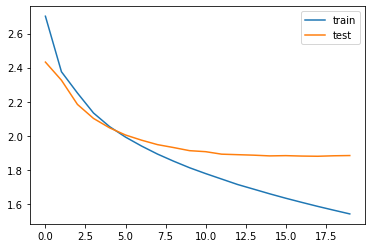

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 10. Implementing the inference model

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print("Gotcha")

Gotcha


**`seq2seq`는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로, 그에 맞게 모델 설계를 별개로 진행해야 합니다.**

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한 번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 모델 하나만 준비하겠습니다. 그러나 정답 문장이 없는 인퍼런스 단계에서는 생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하므로 부득이 인퍼런스를 위한 모델 설계가 별도로 필요합니다. 이 때에는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print("Gotcha")

Gotcha


어텐션 메커니즘을 사용하는 출력층을 설계해 봅시다.

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print("Gotcha")

Gotcha


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어 볼까요?

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

print("Gotcha")

Gotcha


**Q. 정답 문장이 없는 추론 Inference 단계에서는 왜 모델 설계를 별도로 해주어야 하나요?**
```
생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야하기 때문입니다.
```

### 11. Test

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠? 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어 봅시다. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들겠습니다.

**Q. seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
(요약문에는 sostoken과 eostoken을 고려)**

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
            temp += tar_index_to_word[i] + ' '
    return temp

print("Gotcha")

Gotcha


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해 봅시다.

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : two cats love surprised since picky eaters comes good price well 
실제 요약 : great price 
예측 요약 :  cat treats


원문 : best organic coffee ever enjoyed aroma taste like good french roast full rich flavor product price customer service excellent 
실제 요약 : delicious 
예측 요약 :  great coffee


원문 : keep car case starting feel tired one taste best job 
실제 요약 : good for pick me up 
예측 요약 :  great taste


원문 : tea strange taste enjoyable buying flavor look elsewhere present tea cheap tasting 
실제 요약 : weird taste flavors 
예측 요약 :  not what expected


원문 : ordered coffee amazon friday special one advertized bold like strong cup coffee bitter one hits taste really nice bad taste keurig years coffee two favorites far tully italian roast gets top spot less expensive keep list run 
실제 요약 : my new favorite 
예측 요약 :  not bitter


원문 : husband love bars great healthy alternative breakfast bars contain high fructose corn syrup junk put products tried chocolate chocolate peanut butter also pleased berry b

많은 결과문이 출력 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보입니다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 합니다. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

물론 그다지 좋지 않은 요약의 예도 꽤나 보입니다. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법이 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더-디코더 자체의 구조를 새롭게 변경하는 트랜스포머(Transformer)와 같은 다양한 개선 방안들이 있습니다. 이런 방안들에 대해서도 향후 살펴보겠습니다.

### 12. Extractive Summarization

앞서 seq2seq를 통해서 추상적 요약을 진행했습니다.  
그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있습니다!

**Q. 우리가 앞에서 seq2seq 모델을 사용하여 추상적 요약을 했습니다. 그렇다면 추출적 요약은 무엇일까요?**
```
추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식입니다. 그래서 생성된 문장이나 단어는 원문에 포함되어 있기 때문에, 단점으로 언어 표현 능력이 제한되어 생성된 문장이 매끄럽지 않을 수 있습니다. 대표적인 알고리즘으로는 TextRank가 있습니다.
```

**패키지 설치**

```
$ pip list | grep summa
```

**데이터 다운로드하기**

In [ ]:
import requests
from summa.summarizer import summarize

매트릭스 시놉시스를 다운로드 하겠습니다.

In [ ]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

text에는 매트릭스 시놉시스가 문자열로 저장되어 있습니다. 출력 결과가 아주 길기 때문에 일부만 출력하고, 저장이 잘 되었는지 확인해 봅시다.

In [ ]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

**summarize 사용하기**

`Summa`의 `summarize()`에 인자로 사용되는 값들에 대해서 알아볼까요?

* text (str) - 요약할 텍스트.
* ratio (float, optional) – 요약문과 원본에서 선택되는 문장의 비율. 0~1 사이의 값.
* words (int or None, optional) – 출력에 포함할 단어의 수.
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시합니다.
* split (bool, optional) – True면 문장 list, False는 조인(join)된 문자열을 반환.

`Summa`의 `summarize`는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여 보겠습니다. 원문의 0.005%를 출력하도록 설정해 봅시다.

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 설정하면 됩니다.

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어의 수로 요약문의 크기를 조절할 수 있습니다. 단어를 50개만 선택해 봅시다.

In [ ]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


amazon_review data를 활용하여 `Extractive/Abstractive summarization` 이해하기 위해 위와 같이 단어장 크기를 줄이는 다양한 `text normalization` 적용하여 자연어 처리 작업을 실습하였고, `seq2seq` 모델의 성능을 향상시키는 `Attention Mechanism` 적용해 봤습니다.